In [172]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, pred_length):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length

    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx+self.seq_length]
        target_seq = self.data[idx+self.seq_length:idx+self.seq_length+self.pred_length]
        return torch.tensor(input_seq), torch.tensor(target_seq)

def prepare_data(data, seq_length, pred_length, batch_size, shuffle=True):
    dataset = TimeSeriesDataset(data, seq_length, pred_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [173]:
from torch.utils.data import random_split
'''
    使用Subset类将前 train_size 个数据点分配给训练集，
    剩余的数据点分配给测试集。这样做可以保持数据集的原始顺序，不会进行随机打乱
'''
from torch.utils.data import Dataset, Subset

def prepare_data(data, seq_length, pred_length, batch_size, shuffle=False):
    dataset = TimeSeriesDataset(data, seq_length, pred_length)
    # 计算训练集、验证集和测试集的大小
    train_size = int(0.7 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # 分配数据集为训练集、验证集和测试集
    train_dataset = Subset(dataset, list(range(train_size)))  # 使用前70%的数据点作为训练集
    val_dataset = Subset(dataset, list(range(train_size, train_size + val_size)))  # 使用接下来的20%的数据点作为验证集
    test_dataset = Subset(dataset, list(range(train_size + val_size, len(dataset))))  # 使用剩余的10%的数据点作为测试集

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return train_loader, val_loader, test_loader

In [174]:
# data = [i for i in range(100)]

import pandas as pd
data = pd.read_csv('../频域法/data_normed.txt').values.tolist()
len(data)

8191

In [175]:
seq_length = 64  # 训练窗口
batch_size = 16
pred_length = 8  # 预测窗口

train_loader, val_loader, test_loader= prepare_data(data, seq_length, pred_length, batch_size)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))
# for inputs, targets in test_loader:
#     print("Input sequence:", inputs)
#     print("Target value:", targets)
#     print()
#     i = i + 1
#     if i == 2:
#         break

5684 1624 812


In [176]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
  
  def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers=1, n_deep_layers=10, use_cuda=False, dropout=0.2):
    '''
    n_features: 输入特征的数量（对于单变量预测，为1）
    n_hidden: 每个隐藏层中的神经元数量
    n_outputs: 每个训练样本要预测的输出数量
    n_deep_layers: LSTM 层后的隐藏稠密层数量
    sequence_len: 用于预测的步长
    dropout: 浮点数 (0 < dropout < 1)，表示隐藏层之间的 dropout 比率
    '''
    super().__init__()
    
    self.n_lstm_layers = n_lstm_layers
    self.nhid = n_hidden
    self.use_cuda = use_cuda # 设置是否使用 CUDA 加速
    
    # LSTM 层
    self.lstm = nn.LSTM(n_features,
                        n_hidden,
                        num_layers=n_lstm_layers,
                        batch_first=True) # 因为我们已经将数据转换成了这种形式
    
    # LSTM 层后的第一个稠密层
    self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden)
    
    # Dropout 层
    self.dropout = nn.Dropout(p=dropout)
    
    # 创建隐藏稠密层（n_hidden x n_deep_layers）
    dnn_layers = []
    for i in range(n_deep_layers):
      # 最后一层 (n_hidden x n_outputs)
      if i == n_deep_layers - 1:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, n_outputs))
      # 其他层 (n_hidden x n_hidden)，并可选择添加 dropout
      else:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, nhid))
        if dropout:
          dnn_layers.append(nn.Dropout(p=dropout))
    # 编译隐藏稠密层
    self.dnn = nn.Sequential(*dnn_layers)
  
  def forward(self, x):
    
    # 初始化隐藏状态
    hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    
    # 将隐藏状态移动到设备上
    if self.use_cuda:
      hidden_state = hidden_state.to(device)
      cell_state = cell_state.to(device)
      
    self.hidden = (hidden_state, cell_state)
    
    # 前向传播
    x, h = self.lstm(x, self.hidden) # LSTM 层
    x = self.dropout(x.contiguous().view(x.shape[0], -1)) # 将 LSTM 输出展平
    x = self.fc1(x) # 第一个稠密层
    return self.dnn(x) # 通过全连接的 DNN 进行进一步前向传播。


In [177]:
nhid = 96  # 隐藏层中节点的数量
n_dnn_layers = 8  # 隐藏稠密层数量

# 特征数量（因为这是单变量时间序列分析，所以将其设置为1。多变量分析将在未来加入）
n_features = 1  

# 设备选择 (CPU | GPU)
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'

# 初始化模型
model = LSTMForecaster(n_features, nhid, pred_length, seq_length, n_deep_layers=n_dnn_layers, use_cuda=USE_CUDA).to(device)


In [178]:
# Set learning rate and number of epochs to train over  
lr = 4e-4  
n_epochs = 100  

# Initialize the loss function and optimizer  
criterion = nn.MSELoss().to(device)  
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [179]:
# 用于存储训练和验证损失的列表
t_losses, v_losses = [], []

print(f'device: {device}')

# 循环迭代训练轮次
for epoch in range(n_epochs):
  train_loss, valid_loss = 0.0, 0.0
  
  # 训练步骤
  model.train()
  
  # 循环迭代训练数据集
  for x, y in train_loader:
    optimizer.zero_grad()
    
    # 将输入移动到设备上
    x = x.to(device)
    y = y.squeeze().to(device)
    
    # 前向传播
    preds = model(x).squeeze()
    loss = criterion(preds, y)  # 计算批次损失
    train_loss += loss.item()
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()

  epoch_loss = train_loss / len(train_loader)
  t_losses.append(epoch_loss)
  
  # 验证步骤
  model.eval()
  
  # 循环迭代验证数据集
  for x, y in val_loader:
    with torch.no_grad():
      x, y = x.to(device), y.squeeze().to(device)
      preds = model(x).squeeze()
      error = criterion(preds, y)
    valid_loss += error.item()
  
  valid_loss = valid_loss / len(val_loader)
  v_losses.append(valid_loss)
  
  if epoch % 10 == 0:
    print(f'{epoch} - 训练损失: {epoch_loss}, 验证损失: {valid_loss}')


device: cuda
0 - 训练损失: 0.040629669328042295, 验证损失: 0.004470133002363511
10 - 训练损失: 0.006617964049827391, 验证损失: 0.0024636190307016173
20 - 训练损失: 0.005323757440063663, 验证损失: 0.0015070814372259466
30 - 训练损失: 0.004654763609476994, 验证损失: 0.0017276386189384058
40 - 训练损失: 0.003968426084938574, 验证损失: 0.0017888778364103213
50 - 训练损失: 0.00362360934835461, 验证损失: 0.0019496812207816059
60 - 训练损失: 0.0033388631166550173, 验证损失: 0.0019431179503490235
70 - 训练损失: 0.0030737642690623073, 验证损失: 0.0018799812789759872
80 - 训练损失: 0.0029780676453034236, 验证损失: 0.0020067673250713258
90 - 训练损失: 0.002864309879911938, 验证损失: 0.0019118598343886655


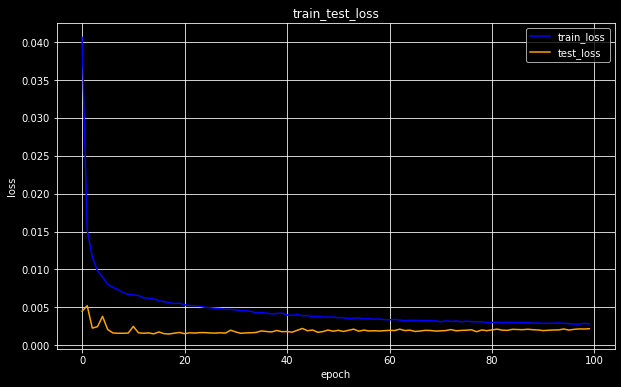

In [180]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, valid_losses):
    # 绘制训练损失和验证损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='train_loss', color='blue')
    plt.plot(valid_losses, label='test_loss', color='orange')

    # 添加标题和标签
    plt.title('train_test_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    # 添加图例
    plt.legend()

    # 显示网格线
    plt.grid(True)

    # 显示图像
    plt.show()

plot_losses(t_losses, v_losses)

In [200]:
model.eval()

import numpy as np

predictions, pred_value = [], []
with torch.no_grad():
    for data in test_loader:
        inputs = data[0].to(device)  # 获取输入数据
        outputs = model(inputs)  # 进行预测
        predictions.append(outputs.cpu().numpy())  # 将预测结果添加到列表中
predictions = np.concatenate(predictions, axis=0)  # 将多个批次的预测结果合并成一个数组

In [201]:
for data in predictions:
    pred_value.append(data.mean())
pred_value.__len__()

data = pd.read_csv('../频域法/data_normed.txt').values.tolist()
real_value = data[7379:]
real_value.__len__()

812

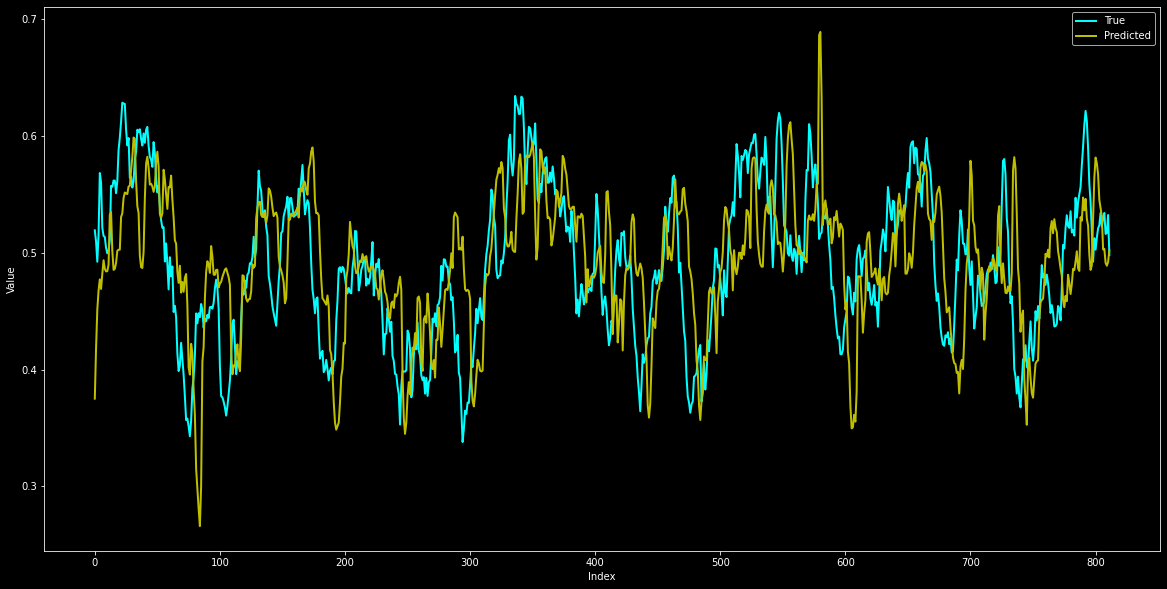

In [202]:
import matplotlib.pyplot as plt

N = real_value.__len__()

pred_value_pic1 = pred_value[:N]
real_value_pic1 = real_value[:N]

plt.figure(figsize=(20, 10))

# 绘制真实值的折线图
plt.plot(range(len(real_value_pic1)), real_value_pic1, label='True', c='cyan', linewidth=2)

# 绘制预测值的折线图
plt.plot(range(len(pred_value_pic1)), pred_value_pic1, label='Predicted', c='y', linewidth=2)

plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [211]:
# 更直观版

# 真实数据
real_data = pd.read_csv('../频域法/data_normed.txt').values.tolist()
pre_data = pd.read_csv('../频域法/data_normed.txt').values.tolist()
for i in range(812):
    # print(pre_data[7378+i] == pred_value[i])
    pre_data[7378+i][0] = pred_value[i]

In [235]:
len(real_data), len(pre_data)

False

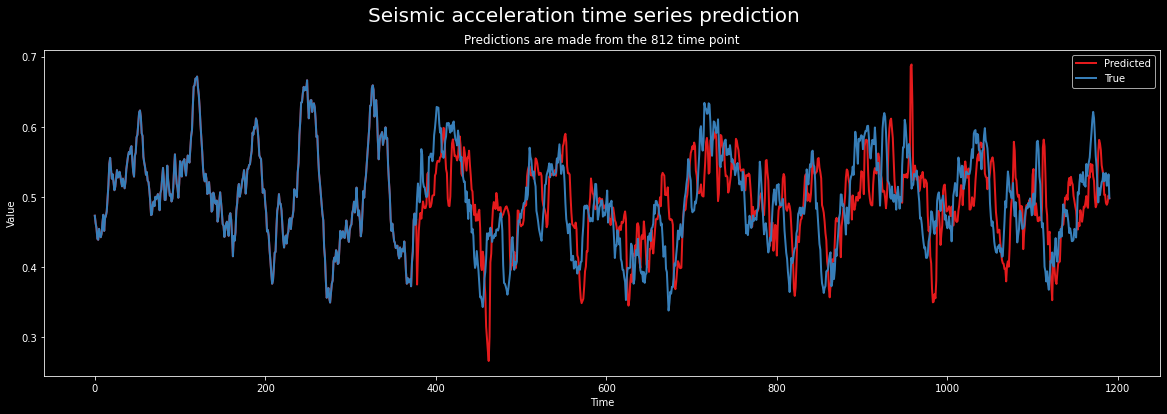

In [242]:
import seaborn as sns

plt.figure(figsize=(20, 6))

sns.set_palette("Set1")

M = 7000
real_data_p2 = real_data[M:]
pre_data_p2 = pre_data[M:]

# 绘制预测值的折线图
plt.plot(range(len(pre_data_p2)), pre_data_p2, label='Predicted', linewidth=2)

# 绘制真实值的折线图
plt.plot(range(len(real_data_p2)), real_data_p2, label='True', linewidth=2)

plt.title('Predictions are made from the 812 time point')
plt.suptitle('Seismic acceleration time series prediction', fontsize=20)

plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()